## Results Processing

In [2]:
import os 
from dotenv import dotenv_values
import pandas as pd
from langfuse import Langfuse
import numpy as np
import ast  
langfuse = Langfuse()

In [3]:
for i,v in dotenv_values().items():
    globals()[i]=v 

RESULTS_FOLDER = os.path.join(PROJECT_DIR, "results")

In [4]:
def langfuse_run_ids(dataset_name, dataset_run_name):
    dataset_run = langfuse.get_dataset_run(
    dataset_name=dataset_name, dataset_run_name=dataset_run_name
    )
    trace_ids = [run_item.trace_id for run_item in dataset_run.dataset_run_items]
    return trace_ids

In [5]:
def open_results(dataset):
    return pd.read_csv(os.path.join(RESULTS_FOLDER, dataset))

In [6]:
def parse_cell(cell):
    if isinstance(cell, str) and cell.startswith('[') and cell.endswith(']'):
        try:
            value = ast.literal_eval(cell)
            return value[0] if isinstance(value, list) and len(value) == 1 else np.nan
        except:
            return np.nan
    return cell

In [7]:
def get_results(dataset):
    columns=['precision', 'recall', 'f1', 'semantic similarity', 'jaccard_similarity', 'r_precision', 'r_recall']
    dataset[columns] = dataset[columns].fillna(0).applymap(parse_cell)
    df = dataset[columns].copy()
    metrics = df.mean(skipna=True).to_dict()
    metrics['hallucinations'] = df[df['semantic similarity'] == -1].shape[0]
    return metrics

In [9]:
# trace_ids = langfuse_run_ids("GSCESP", "NoHybrid-gpt-4.1-mini") #"2025-04-27_11-43-07"
trace_ids = langfuse_run_ids("GSCESP", "NoHybrid-o4mini") #

results = open_results("25052025.csv")
results = results[results.id.isin(trace_ids)]
results.shape

(226, 36)

In [164]:
results.timestamp = pd.to_datetime(results['timestamp'])
results = results[results.timestamp < '2025-05-14 18:00:00'] 
results.shape

(117, 36)

In [29]:
import json
json.loads(results['metadata'].iloc[0])['dataset_item_id']

'704083a1-6c58-4bf3-9f23-dc176cb231f1'

In [42]:
def get_dataset_item_id(row):
    try:
        return json.loads(row)['dataset_item_id']
    except:
        return None

In [47]:
results['item_id' ] = results['metadata'].apply(lambda x: get_dataset_item_id(x) )
results = results[~results.item_id.isna()]

/var/folders/d6/gvk9_zmj13704s2_fj12rw680000gn/T/ipykernel_4982/3162676464.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['item_id' ] = results['metadata'].apply(lambda x: get_dataset_item_id(x) )


In [11]:
import json

def convert_2_json(s):
    try: 
        return json.loads(s)
    except:
        return None
results.output = results['output'].apply(convert_2_json)
results.input = results['input'].apply(convert_2_json)

In [12]:
n_candidates = results['output'].apply(lambda x: len(x['final_answer']) if x is not None else None)
len_cc = results['input'].apply(lambda x: len(x['clinical_note'].split(' ')) if x is not None else None )

In [13]:
n_candidates.mean()

7.5181818181818185

<Axes: >

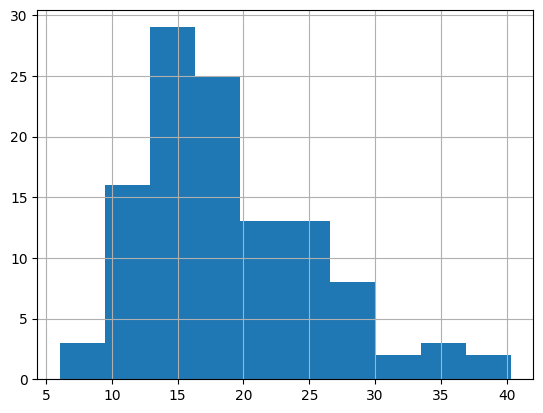

In [168]:
(len_cc /n_candidates).hist()

In [106]:
n_candidates/len_cc

147    0.042056
148    0.042056
149    0.046843
150    0.050459
151    0.063107
         ...   
257    0.037791
258    0.036269
260    0.045024
261    0.040134
262    0.043197
Length: 115, dtype: float64

In [169]:
traces = results['id'].apply(langfuse.fetch_trace)
traces = traces.apply(lambda x: x.data)

In [94]:
[obs.input for obs in traces.iloc[0].observations if obs.name == "VectorStoreRetriever"]

['masa mesentérica de 3,4 cm en el lado izquierdo',
 'posible desmoide',
 'pólipos hiperplásicos',
 'adenoma tubular',
 'esófago de Barrett',
 'innumerables pólipos de diversos tamaños de hasta 1,5 cm en todo el colon',
 'múltiples pólipos adenomatosos de la glándula fúndica',
 'obesidad mórbida',
 'innumerables pólipos en el resto del fondo y cuerpo gástricos, compatibles con pólipos de glándula fúndica']

In [170]:
def get_first_GEN(trace):
    obs = [obs for obs in trace.observations if obs.type == 'GENERATION']
    sorted_obs = sorted(obs, key=lambda obs: obs.start_time)
    return sorted_obs[0]
first_obs = traces.apply(lambda x: get_first_GEN(x))

In [171]:
def get_second_GEN(trace):
    obs = [obs for obs in trace.observations if obs.type == 'GENERATION']
    sorted_obs = sorted(obs, key=lambda obs: obs.start_time)
    return [obs.usage_details for obs in sorted_obs[1:]]
second_obs = traces.apply(lambda x: get_second_GEN(x))

In [182]:
def get_output(obs):
    try:
        return obs['output_reasoning']
    except:
        return np.nan

In [185]:
np.nanmean([get_output(obs) for obs_list in second_obs for obs in obs_list], )

193.75686274509803

In [161]:
token_count = [(cc, obs['input']) for cc, obs_list in zip(len_cc.values, second_obs) for obs in obs_list if not pd.isna(cc)]
X = [a[0] for a in token_count]
Y = [a[1] for a in token_count]

In [96]:
def get_retrieved_text(trace):
    return [obs.input for obs in trace.observations if obs.name == "VectorStoreRetriever"]

retrieved_texts = traces.apply(lambda x: get_retrieved_text(x))

In [100]:
import numpy as np
np.mean([len(y.split(' ')) for x in retrieved_texts for y in x])

4.729319627998042

In [91]:
# first_tokens = first_obs.apply(lambda x: x.usage_details['output_reasoning'] if 'output_reasoning' in x.usage_details else None)
first_tokens = first_obs.apply(lambda x: x.usage_details['output'] if 'output' in x.usage_details else None)
# first_tokens = first_obs.apply(lambda x: x.calculated_total_cost)

In [92]:
first_tokens.mean()

902.1025641025641

In [170]:
(first_tokens / n_candidates).mean()

187.13035910323492

In [146]:
nan_idxs_c  =set(n_candidates.loc[~n_candidates.isna()].index)
nan_idxs_f  = set(first_tokens.loc[~first_tokens.isna()].index)

n_candidates = n_candidates.loc[nan_idxs_c & nan_idxs_f]
first_tokens = first_tokens.loc[nan_idxs_c & nan_idxs_f]

/var/folders/d6/gvk9_zmj13704s2_fj12rw680000gn/T/ipykernel_11905/3386054616.py:4: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  n_candidates = n_candidates.loc[nan_idxs_c & nan_idxs_f]
/var/folders/d6/gvk9_zmj13704s2_fj12rw680000gn/T/ipykernel_11905/3386054616.py:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  first_tokens = first_tokens.loc[nan_idxs_c & nan_idxs_f]


In [162]:
from sklearn.linear_model import LinearRegression
import numpy as np

# Reshape n_candidates to 2D array for sklearn
# X = n_candidates.values.reshape(-1, 1)
# y = token_count
X = np.array(X).reshape(-1,1)

model = LinearRegression()
model.fit(X, Y)

print(f"Intercept: {model.intercept_}")
print(f"Coefficient: {model.coef_[0]}")

Intercept: 903.1436511310823
Coefficient: 0.33837980776180027


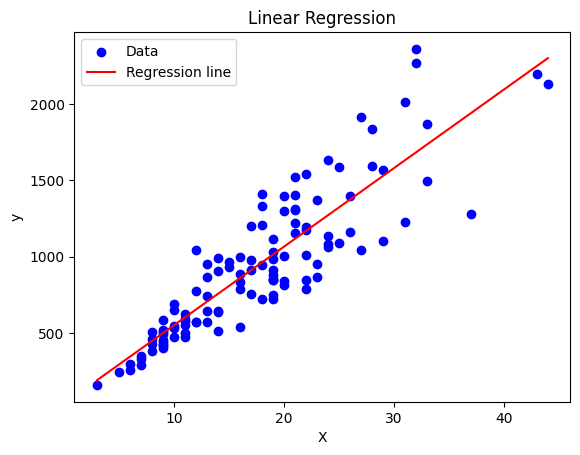

In [109]:
import matplotlib.pyplot as plt
# Scatter plot of the data
plt.scatter(X, y, color='blue', label='Data')

# Regression line
x_line = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
y_line = model.predict(x_line)

plt.plot(x_line, y_line, color='red', label='Regression line')

plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.title('Linear Regression')
plt.show()

In [34]:
(first_tokens / n_candidates).mean()

56.76732134114636

In [24]:
first_obs.iloc[0].promptTokens

882

In [88]:
traces.data.observations

[ObservationsView(id='8eeeab35-5db7-4b16-95b7-b94eaaf0d1ea', trace_id='f2b8b83b-5f36-4999-9416-ef62dcb992e4', type='SPAN', name='custom_chain', start_time=datetime.datetime(2025, 5, 14, 17, 29, 10, 47000, tzinfo=datetime.timezone.utc), end_time=datetime.datetime(2025, 5, 14, 17, 29, 20, 54000, tzinfo=datetime.timezone.utc), completion_start_time=None, model=None, model_parameters=None, input={'clinical_note': 'Un hombre de 44 años con obesidad mórbida e índice de masa corporal (IMC 63) se sometió a una gastrectomía en manga para perder peso y se le encontraron múltiples pólipos adenomatosos de la glándula fúndica en la patología final. El estudio posterior incluyó una esofagogastroduodenoscopia que reveló innumerables pólipos en el resto del fondo y cuerpo gástricos, compatibles con pólipos de glándula fúndica, duodeno normal sin pólipos y esófago de Barrett. La colonoscopia fue significativa para innumerables pólipos de diversos tamaños de hasta 1,5 cm en todo el colon, con relativa p

In [15]:
get_results(results)

{'precision': 0.6276099696712942,
 'recall': 0.562891709499326,
 'f1': 0.5871794871794872,
 'semantic similarity': 0.5467914886693027,
 'jaccard_similarity': 0.43817907596003935,
 'r_precision': 0.17869935724748123,
 'r_recall': 0.6535446489431067,
 'hallucinations': 0}

In [ ]:
The addition of fuzzy matching allowed for a significant increase in the F1-score, which went up to 0.61. In this case the precision remained 0.63 and was thus in the recall were the difference was. The recall increased up to 0.60. The close alignment between precision and recall in this case indicates a well-balanced and reliable system. Additionally, the semantic similarity between predicted and gold-standard codes reached 0.57, suggesting a good conceptual match beyond exact code overlap. Fuzzy matching allows for including HPO candidates that are retrieved by using the phenotype the \acrshort{llm} inferred. That is, the search does not use parts of the original text. Thanks to this implementation, more implicit phenotypes  from the real set are detected and thus the recall increases. 

<Axes: >

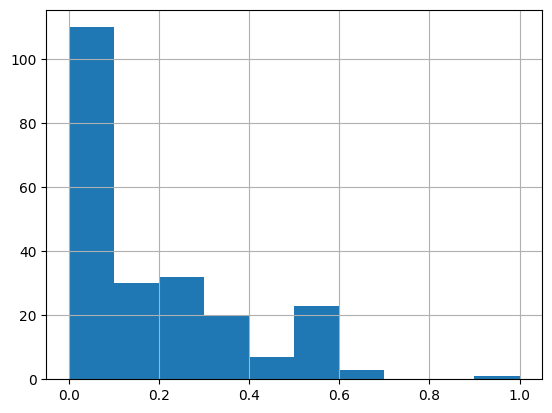

In [72]:
results.precision.hist()

In [ ]:
from scipy.stats import wilcoxon

stat, p_value = wilcoxon(results.precision.hist(), v2)
print(f"Wilcoxon = {stat}, p = {p_value}")
